# C. Elegans
In this notebook we analyze a correlation network of neural activations of the nematode worm Caenorhabditis Elegans. C. Elegans has become a model organism due to the unique characteristic of each individual sharing the exact same nervous system structure. <br>
The minimal homological scaffold of its brain map highlights the *geometry* of the obstruction patterns, i.e. the precise areas where nervous stimuli are less likely to flow. <br>
Data courtesy of __[G.Petri](https://github.com/lordgrilo/Holes)__.

Import the libraries

In [5]:
# source files are two folders above
import sys
sys.path.append('../../src')

import Driver
import Geometry
import Scaffold

import math
import numpy as np
from random import random
import networkx as nx
import pickle as pk
import matplotlib.pyplot as plt

sys.path.append('../../')
import Holes as ho

Data is stored as a *networkx* graph.

In [9]:
G = nx.read_weighted_edgelist('./celegans_weighted_undirected.edges')

# convert to weighted adj matrix
W = nx.adjacency_matrix(G,weight='weight').todense()

# invert correlations to obtain a distance
W = np.reciprocal(W)
W[W==np.inf] = 0 # revert inf to zeros

# build the correct graph
G = nx.Graph(W)

/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:7: RuntimeWarning: divide by zero encountered in reciprocal
  import sys


Set the number of nodes

In [10]:
NV = G.number_of_nodes()

### Holes
We first compute the loose scaffold.

In [11]:
# Compute the filtration
fil = ho.filtrations.upward_weight_clique_rank_filtration(G)
clique_dictionary_file = './celegans_filtration.pck'
pk.dump(fil,open(clique_dictionary_file,'wb'), protocol=2)

hom_dim = 1
dataset_tag = 'celegans'
output_dir = './';

# Compute the generators
ho.persistent_homology_calculation(clique_dictionary_file, hom_dim, dataset_tag, output_dir,m1=512, m2=2048,save_generators=True)

# Dump the results in this file
gen_file = './gen/generators_celegans_.pck'
gen = pk.load(open(gen_file, 'rb'))

Preliminary scan of edge weights to define filtration steps...
Constructing filtration...
Max filtration value: 30
Clique dictionary created.
Calling: jython  ../../Holes/jython_utils/persistent_homology_calculation.py ./celegans_filtration.pck 1 ./ celegans_ /Users/marco/javaplex/ True
0


Child returned 0


Aggregate the homological scaffold and write it to file.

In [13]:
ScafH = nx.Graph()
ScafH.add_nodes_from(G)

edges = []

for c in gen[1]:
    edges.extend(c.cycles())
    
for e in edges:
    u , v = int(e[0]) , int(e[1])
    if ScafH.has_edge(u,v):
        ScafH[u][v]['weight'] += 1
    else:
        ScafH.add_edge(u, v, weight=1)

# Write scaffold to file    
out_file = './Scaffolds/JPScaffold.pck'
pk.dump(ScafH, open(out_file,'wb'))

Draw the loose scaffold.

/usr/local/lib/python3.7/site-packages/networkx/drawing/nx_pylab.py:611: MatplotlibDeprecationWarning: isinstance(..., numbers.Number)
  if cb.is_numlike(alpha):


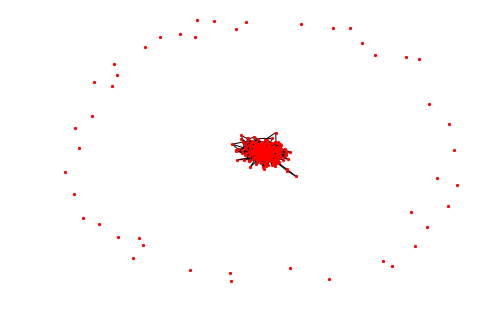

In [14]:
nx.draw(ScafH, node_size=5)

### Minimal Scaffold
Now compute the minimal homological scaffold of the same network. <br>
This, on a desktop machine, is extremely computationally heavy. The progress can be visualized by printing the content of file `monitor` in a shell.

In [22]:
# get filtration steps
epsList = Geometry.genFullEpsList(W)

# Knowing in advance which subset of the filtration has nontrivial homology,
# one could slice it to avoid useless computations
pass

# set tracking output file
out_file = './monitor'

# now the heavy-lifting
Filtr = Driver.getFiltrBasis(W, epsList, Draws=True, parallel=True,monitor='./monitor')

Write the filtration to disk, so one can read it next time and does not have to compute it again!

In [23]:
# dump the filtration of SHB 
filtr_out = './gen/CEMinFiltr.pck'
pk.dump(Filtr, open(filtr_out,'wb'))

Next aggregate the minimal scaffold.

In [25]:
S = Scaffold.frequency_Scaffold(Filtr , NV)
Scaf = nx.from_numpy_matrix(S, parallel_edges=False)

out_file = './Scaffolds/MinScaffold.pck'
pk.dump(Scaf, open(out_file,'wb'))

Draw the scaffold.

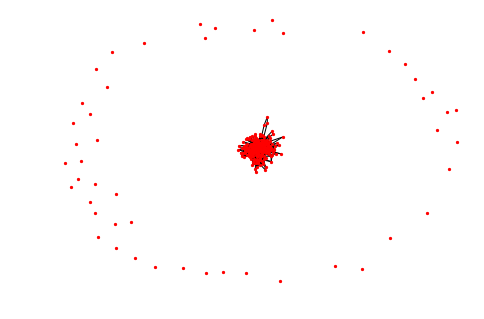

In [26]:
nx.draw(Scaf, node_size=5)